In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

In [102]:
iris = sns.load_dataset('iris')

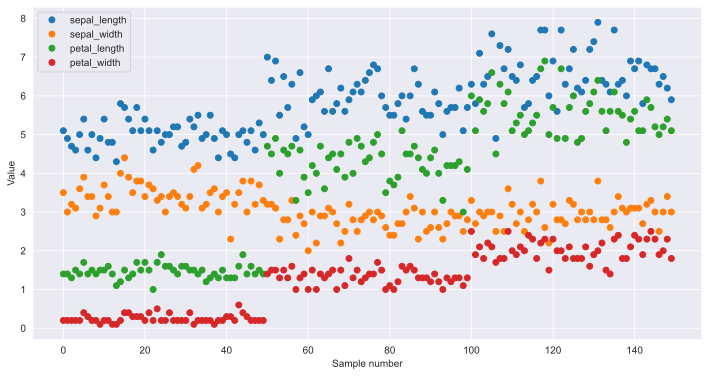

In [103]:
# plot the data
iris.plot(marker="o",linestyle="None",figsize=(12,6))
plt.xlabel("Sample number")
plt.ylabel("Value")
plt.show()

In [104]:
# convert pandas to tensor
data = torch.tensor(iris[iris.columns[0:4]].values, dtype=torch.float)

# label encoding
labels = torch.zeros(data.shape[0],dtype=torch.long)

labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

In [105]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

train_data = TensorDataset(torch.Tensor(train_data),torch.Tensor(train_labels))

test_data = TensorDataset(torch.Tensor(test_data),torch.Tensor(test_labels))

batchSize = 54
train_loader = DataLoader(train_data,shuffle=True,batch_size=batchSize,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [106]:
def createNet():
    
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )
    
    
    lossFn = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.0005)
    
    return ANNiris,lossFn,optimizer

In [107]:

num_epochs = 1000

def trainNet():
    
    # init accurascies as empties
    trainAcc = []
    testAcc = []
    losses = []
    
    for epochI in range(num_epochs):
        
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            
            yHat = ANNiris(X)
            loss = lossFn(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            batchAcc.append(100*torch.mean((torch.argmax(yHat,dim=1) == y).float()).item())
            batchLoss.append(loss.item())
            
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        X,y = next(iter(test_loader))
        predLabels = torch.argmax(ANNiris(X),dim=1)
        testAcc.append(100*torch.mean((predLabels == y).float()).item())
        
            
    return trainAcc,testAcc,losses 

In [108]:
ANNiris,lossFn,optimizer = createNet()

trainAcc,testAcc,losses = trainNet()

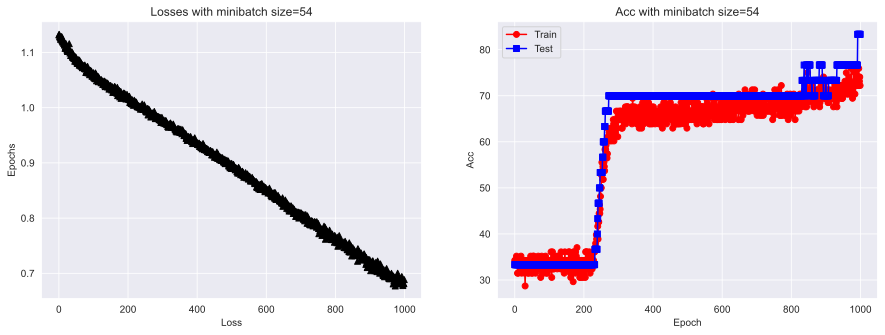

In [109]:
fig ,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(losses,'k^-')
ax[0].set_xlabel("Loss")
ax[0].set_ylabel("Epochs")
ax[0].set_title("Losses with minibatch size=" + str(batchSize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Acc")
ax[1].set_title("Acc with minibatch size=" + str(batchSize))
ax[1].legend(["Train","Test"])

plt.show()

# Testing Batch sizes

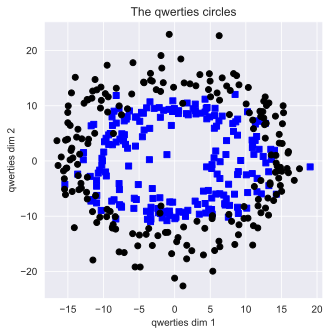

In [110]:
nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [r1*np.cos(th) + np.random.randn(nPerClust) * 3 , 
     r1*np.sin(th) + np.random.randn(nPerClust)]
b = [r2*np.cos(th) + np.random.randn(nPerClust),
     r2*np.sin(th) + np.random.randn(nPerClust) * 3]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concate to matrix
data_np = np.hstack((a,b)).T 

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels == 0)[0],0],data[np.where(labels == 0)[0],1],'bs')
plt.plot(data[np.where(labels == 1)[0],0],data[np.where(labels == 1)[0],1],'ko')
plt.title("The qwerties circles")
plt.xlabel("qwerties dim 1")
plt.ylabel("qwerties dim 2")
plt.show()

In [111]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.2)

# convert into pytorch datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

# translate into data loader
train_batchSize = 16
test_batchSize = test_data.tensors[0].shape[0]
train_loader = DataLoader(train_data,batch_size=train_batchSize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_batchSize)

In [112]:
class Net(nn.Module):
     def __init__(self,dropoutRate):
        super().__init__()
        
        ### layers
        self.input = nn.Linear(2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128,1)
        
        # parameters
        self.dr = dropoutRate
         
     def forward(self, x):
         
         x = F.relu(self.input(x))
         
         # dropout after input layer , self.training means is set true when model is in train mode
         x = F.dropout(x, p=self.dr,training=self.training)
         
         x = F.relu( self.hidden(x) )
         
         x = F.dropout(x, p=self.dr,training=self.training)
         
         x = self.output(x)
         
         return x

In [113]:
# function to create model
def createQerNet(dropoutRate):
    
    ANNQC = Net(dropoutRate)
    
    lossFn = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr=0.002)
    
    return ANNQC, lossFn, optimizer

In [114]:
# train the model
num_epochs = 1000

def trainQerNet(ANNQC, lossFn,optimizer,train_loader,test_loader):
    
    trainAcc = []
    testAcc = []
    
    
    
    for epochI in range(num_epochs):
            
        batchAcc = []
        for X,y in train_loader:
            
            yHat = ANNQC(X)
            loss = lossFn(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            batchAcc.append(100*torch.mean(((yHat >.5) == y).float()).item())
        
        tstAcc = []
        for X,y in test_loader:
            yHat = ANNQC(X)
            tstAcc.append(100*torch.mean(((yHat > .5) == y).float()).item())
        
        trainAcc.append( np.mean(batchAcc))
        testAcc.append(np.mean(tstAcc))
        
    return trainAcc,testAcc

In [115]:
ANNQC,lossFn,optimizer = createQerNet(0)

trainAcc,testAcc =trainQerNet(ANNQC,lossFn,optimizer)

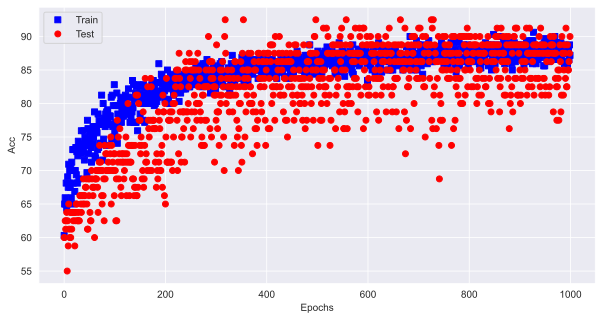

In [116]:
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs')
plt.plot(testAcc,'ro')
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend(["Train","Test"])

plt.show()

### Expreimenting on mini-batch size